<a href="https://colab.research.google.com/github/nericovich/project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект для задачи Яндекс Лицея "Анализ экологических проблем"

### На заводе по производству полезного полимера ООО “Synthesising the future“ обратились за помощью в исследовании зависимостей вредных выбросов от производственных показателей. Требуется повести анализ данных и построить выводы о том, какой этап имеет высокий риск создать повышенное содержания вредного газа.


## Импорты

In [552]:
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind, shapiro

In [553]:
df = pd.read_csv('data.csv', sep=',', decimal='.', skipinitialspace=True)

## Main


### Обработка

In [554]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [555]:
df.head(4)

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
0,2021-01-28 18:00:00,67.83,92.99,474.18,76.84,97.52,49.94,361.50,252.04,97.48,...,108.65,45.59,156.67,19.08,5.92,356.05,NaN,21.48,47.03,2.0
1,2021-01-28 19:00:00,67.83,91.82,473.68,76.15,97.82,48.55,354.75,244.87,97.66,...,108.71,45.89,156.76,19.15,5.94,357.69,NaN,21.48,45.05,2.0
2,2021-01-28 20:00:00,67.83,90.65,473.17,75.46,98.12,47.15,348.00,237.70,97.85,...,108.76,46.19,156.86,19.23,5.97,359.33,NaN,21.48,43.06,2.0
3,2021-01-28 21:00:00,67.93,90.24,473.59,75.26,97.79,49.33,356.74,249.87,97.50,...,108.63,45.87,156.41,19.36,5.97,339.99,0.16,21.48,46.01,2.0


In [556]:
df.dtypes

datetime                                 object
stage_1_output_konv_avd                 float64
stage_2_input_water_sum                 float64
stage_2_output_bottom_pressure          float64
stage_2_output_bottom_temp              float64
stage_2_output_bottom_temp_hum_steam    float64
stage_2_output_bottom_vacuum            float64
stage_2_output_top_pressure             float64
stage_2_output_top_pressure_at_end      float64
stage_2_output_top_temp                 float64
stage_2_output_top_vacuum               float64
stage_3_input_pressure                  float64
stage_3_input_soft_water                float64
stage_3_input_steam                     float64
stage_3_output_temp_hum_steam           float64
stage_3_output_temp_top                 float64
stage_4_input_overheated_steam          float64
stage_4_input_polymer                   float64
stage_4_input_steam                     float64
stage_4_input_water                     float64
stage_4_output_danger_gas               

#### Пропуски

In [557]:
df.isna().sum()

datetime                                   0
stage_1_output_konv_avd                  241
stage_2_input_water_sum                  223
stage_2_output_bottom_pressure           220
stage_2_output_bottom_temp               191
stage_2_output_bottom_temp_hum_steam     177
stage_2_output_bottom_vacuum             231
stage_2_output_top_pressure              182
stage_2_output_top_pressure_at_end       174
stage_2_output_top_temp                  204
stage_2_output_top_vacuum                195
stage_3_input_pressure                   236
stage_3_input_soft_water                 213
stage_3_input_steam                      173
stage_3_output_temp_hum_steam            174
stage_3_output_temp_top                  230
stage_4_input_overheated_steam           169
stage_4_input_polymer                    226
stage_4_input_steam                      244
stage_4_input_water                      241
stage_4_output_danger_gas               3466
stage_4_output_dry_residue_avg           160
stage_4_ou

Надо что-то сделать со всеми, кроме stage_4_output_danger_gas

In [558]:
df[df['work_shift'].isna()]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
1079,2021-11-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1117,2021-11-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1141,2021-11-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1165,2021-11-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1182,2021-11-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4224,2022-10-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4226,2022-10-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4228,2022-10-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4230,2022-10-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Пропуски везде - можно удалить

In [559]:
df = df.dropna(subset=['work_shift'])
print(df['work_shift'].isna().sum())
df['work_shift'].value_counts()

0


work_shift
1.0    2192
2.0    2048
Name: count, dtype: int64

Проверим stage_4_output_product и stage_4_output_dry_residue_avg у них тоже было по 160 пропусков

In [560]:
print(df['stage_4_output_product'].isna().sum())
df['stage_4_output_dry_residue_avg'].isna().sum()

0


0

In [561]:
print(df['stage_4_input_water'].isna().sum())
df[df['stage_4_input_water'].isna()]

81


,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
49,2021-02-01 16:00:00,69.33,122.41,470.79,81.63,93.33,46.68,414.94,211.51,99.18,...,110.37,44.59,156.63,11.18,7.74,NaN,0.24,22.88,37.22,2.0
116,2021-02-06 03:00:00,71.03,134.04,454.07,77.79,97.24,41.80,405.04,205.29,97.70,...,110.85,43.79,156.40,21.11,7.24,NaN,NaN,22.98,52.31,2.0
130,2021-02-06 17:00:00,70.93,127.51,455.09,77.60,99.17,41.20,401.83,201.43,99.66,...,110.67,44.99,156.79,20.70,7.07,NaN,NaN,22.28,47.70,1.0
242,2021-02-14 14:00:00,72.63,131.30,447.16,77.92,97.93,42.43,422.68,211.39,96.14,...,108.74,40.98,157.04,20.32,6.86,NaN,NaN,23.38,45.59,1.0
303,2021-02-18 17:00:00,73.83,123.53,461.95,79.23,101.29,45.85,466.66,229.42,98.87,...,108.47,39.50,157.08,20.16,7.05,NaN,NaN,24.48,46.09,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4006,2022-08-08 16:00:00,59.83,66.94,410.62,82.64,102.21,50.31,498.67,201.81,97.05,...,109.29,31.19,152.69,16.66,4.08,NaN,NaN,19.68,23.63,1.0
4024,2022-08-09 10:00:00,59.03,67.52,469.06,85.47,104.89,65.63,556.81,279.00,99.09,...,116.24,28.29,151.35,27.79,4.14,NaN,NaN,19.68,29.03,1.0
4045,2022-08-12 12:00:00,65.33,91.94,423.30,83.44,110.36,53.13,507.42,212.76,97.48,...,109.35,31.29,151.99,25.80,4.48,NaN,0.13,21.38,27.81,1.0
4253,2022-10-23 09:00:00,63.43,68.70,350.85,77.79,110.29,56.36,406.55,208.21,93.47,...,104.75,41.77,151.83,20.96,4.91,NaN,NaN,22.18,24.40,1.0


Вероятно, ошибки или сбои, тк воду точно подавали

313.7796176965617
303.39


<Axes: xlabel='stage_4_input_water', ylabel='Count'>

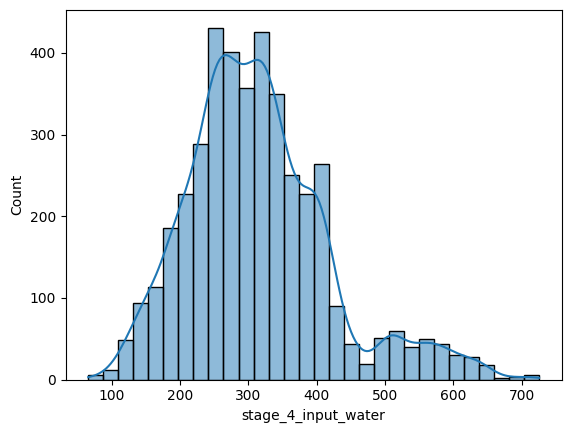

In [562]:
print(df['stage_4_input_water'].mean())
print(df['stage_4_input_water'].median())
sns.histplot(df['stage_4_input_water'], kde=True, bins=30)

Распределение назвать нормальным - трудно, но все же можно заполнить средним

In [563]:
df['stage_4_input_water'] = df['stage_4_input_water'].fillna(df['stage_4_input_water'].mean())
df['stage_4_input_water'].isna().sum()


0

stage_4_input_steam

In [564]:
df[df['stage_4_input_steam'].isna()]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
28,2021-01-31 00:00:00,74.63,114.53,478.53,81.46,97.90,58.06,450.41,289.65,98.35,...,NaN,47.05,156.51,26.05,NaN,449.78,0.18,22.88,55.43,1.0
69,2021-02-02 12:00:00,70.63,119.43,464.96,78.59,95.27,49.33,399.71,248.77,96.06,...,108.90,46.90,156.67,21.31,NaN,405.25,0.19,22.28,55.65,1.0
152,2021-02-07 15:00:00,68.63,129.86,448.78,77.51,96.48,40.49,404.37,199.85,97.53,...,110.87,45.95,156.84,21.04,NaN,414.47,NaN,22.18,48.31,1.0
281,2021-02-17 06:00:00,74.13,116.92,446.33,75.72,98.07,40.05,NaN,205.50,95.94,...,108.17,38.26,156.85,15.83,NaN,366.15,NaN,24.88,41.03,2.0
474,2021-03-02 14:00:00,75.03,111.95,692.52,95.39,101.40,125.36,803.84,363.62,102.27,...,107.89,53.65,156.70,8.85,NaN,436.98,NaN,20.88,59.12,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4229,2022-10-15 12:00:00,66.03,NaN,380.75,80.03,98.96,65.33,417.09,253.41,88.73,...,105.21,44.96,151.27,18.05,NaN,121.41,0.20,20.48,23.73,1.0
4238,2022-10-20 01:00:00,64.73,70.49,358.79,78.17,107.75,59.07,412.53,222.64,93.28,...,103.93,43.42,151.60,21.00,NaN,185.03,0.18,21.68,26.49,1.0
4303,2022-12-08 08:00:00,65.83,NaN,349.69,76.61,79.81,59.96,449.10,315.42,94.58,...,107.61,44.60,151.76,17.15,NaN,160.02,0.15,23.28,16.99,2.0
4357,2022-12-14 12:00:00,65.03,131.45,323.74,73.08,100.00,52.93,335.02,219.84,95.21,...,107.24,48.07,151.64,15.43,NaN,160.60,0.20,23.28,18.15,1.0


5.402151106833494
5.5


<Axes: xlabel='stage_4_input_steam', ylabel='Count'>

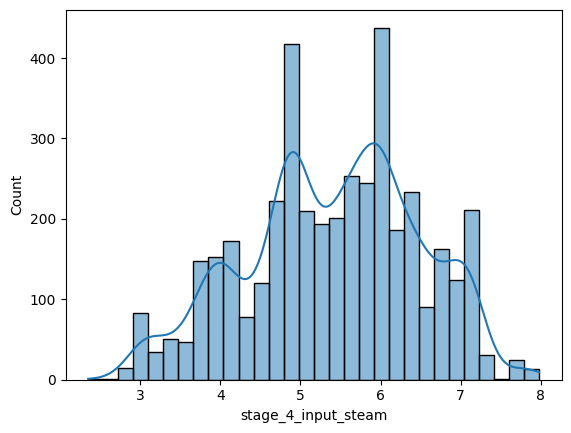

In [565]:
print(df['stage_4_input_steam'].mean())
print(df['stage_4_input_steam'].median())
sns.histplot(df['stage_4_input_steam'], kde=True, bins=30)

In [566]:
df[['stage_4_input_steam', 'stage_4_output_danger_gas']].corr(method='spearman')


,stage_4_input_steam,stage_4_output_danger_gas
stage_4_input_steam,1.000000,0.215835
stage_4_output_danger_gas,0.215835,1.000000


<Axes: xlabel='stage_4_input_steam', ylabel='stage_4_output_danger_gas'>

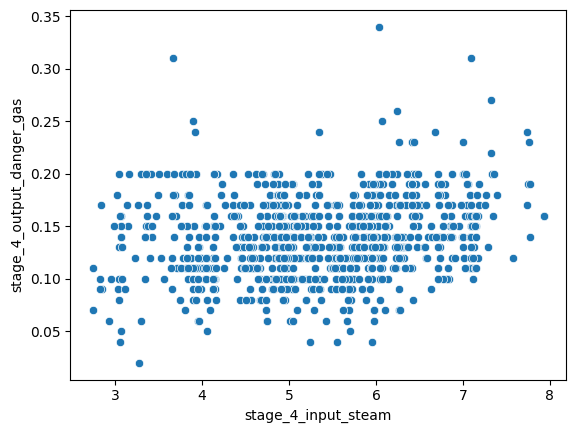

In [567]:
sns.scatterplot(x='stage_4_input_steam', y='stage_4_output_danger_gas', data=df)


Заполню медианой пожалуй)))

Распределение признака является бимодальным, что может указывать на наличие двух различных подгрупп в данных. Несмотря на это, ранговая корреляция Спирмена между признаками составляет 0.22, что говорит о слабой положительной зависимости.


In [568]:
df['stage_4_input_steam'] = df['stage_4_input_steam'].fillna(df['stage_4_input_steam'].median())
df['stage_4_input_steam'].isna().sum()

0

stage_4_input_polymer

In [569]:
df[df['stage_4_input_polymer'].isna()]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
54,2021-02-01 21:00:00,65.73,121.04,475.97,82.12,94.90,56.82,465.26,284.29,98.40,...,109.76,46.34,156.56,NaN,7.93,436.07,0.16,22.88,64.21,2.0
127,2021-02-06 14:00:00,73.83,127.19,455.95,77.61,99.53,41.30,401.48,201.64,99.95,...,110.65,44.86,156.78,NaN,7.05,413.15,NaN,22.28,47.62,1.0
156,2021-02-07 19:00:00,69.83,130.28,447.63,77.49,95.99,40.37,404.83,199.56,97.14,...,110.91,46.13,157.05,NaN,7.18,414.68,NaN,22.18,48.42,1.0
261,2021-02-15 16:00:00,73.83,113.04,456.45,77.10,100.49,44.75,402.09,233.71,97.26,...,108.83,41.42,156.84,NaN,6.00,333.71,NaN,23.98,42.10,1.0
372,2021-02-23 12:00:00,71.33,113.15,453.23,79.74,92.49,53.57,473.38,280.13,97.22,...,109.08,39.83,156.74,NaN,5.67,348.85,0.12,23.48,43.81,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3665,2022-07-22 12:00:00,65.33,105.12,405.75,82.25,96.59,52.51,488.20,201.93,92.56,...,109.06,38.76,151.65,NaN,5.68,421.67,0.09,20.68,56.31,2.0
3702,2022-07-24 01:00:00,66.83,102.78,417.83,82.97,99.36,52.78,503.79,204.46,95.22,...,109.25,40.71,151.62,NaN,5.66,503.43,NaN,21.18,57.59,1.0
4018,2022-08-09 04:00:00,59.63,67.21,409.14,82.72,103.13,50.99,489.99,201.16,97.74,...,110.17,35.27,151.83,NaN,4.07,518.18,NaN,19.68,27.97,1.0
4134,2022-09-13 14:00:00,64.03,135.67,418.30,82.21,89.28,62.73,503.79,347.25,95.31,...,105.45,44.01,151.73,NaN,5.53,184.26,NaN,19.68,23.91,1.0


20.16280785816962
20.51


<Axes: xlabel='stage_4_input_polymer', ylabel='Count'>

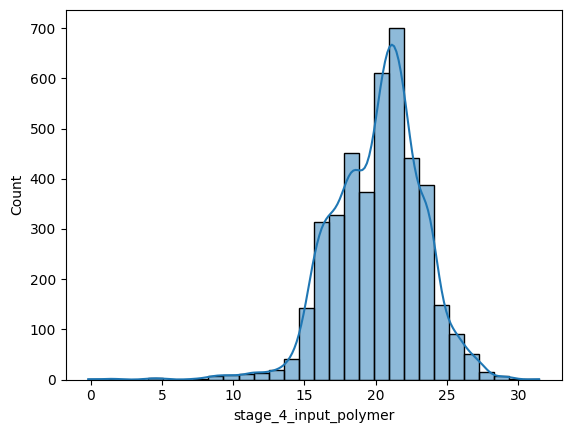

In [570]:
print(df['stage_4_input_polymer'].mean())
print(df['stage_4_input_polymer'].median())
sns.histplot(df['stage_4_input_polymer'], kde=True, bins=30)

Похоже на нормальное, можно средним

In [571]:
df['stage_4_input_polymer'] = df['stage_4_input_polymer'].fillna(df['stage_4_input_polymer'].mean())
df['stage_4_input_polymer'].isna().sum()

0

stage_4_input_overheated_steam подача перегретого пара, в м3

In [572]:
df[df['stage_4_input_overheated_steam'].isna()]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
1088,2021-11-17 09:00:00,68.93,57.05,460.43,77.22,95.33,53.36,624.95,283.22,95.04,...,111.40,47.37,NaN,20.69,4.97,272.200000,NaN,22.28,52.19,1.0
1388,2021-11-30 14:00:00,73.63,88.81,331.36,76.15,110.18,51.13,392.81,220.80,94.32,...,107.89,46.48,NaN,21.14,6.12,297.580000,0.15,23.68,46.61,1.0
1424,2021-12-02 02:00:00,69.63,82.54,360.88,78.72,113.10,57.75,429.76,261.02,96.74,...,109.39,46.74,NaN,22.10,5.95,315.680000,NaN,23.88,46.63,2.0
1474,2021-12-04 14:00:00,70.33,70.48,362.48,78.80,111.86,58.76,436.96,275.01,95.64,...,109.03,45.50,NaN,21.43,5.54,360.110000,NaN,22.18,48.74,1.0
1572,2021-12-08 16:00:00,79.03,48.06,310.89,73.11,123.26,49.97,395.25,246.62,97.45,...,105.90,42.78,NaN,14.55,5.50,313.779618,NaN,22.08,37.33,1.0
1597,2021-12-09 17:00:00,72.83,58.35,356.74,78.07,104.26,58.22,436.49,275.69,95.43,...,108.11,41.18,NaN,22.03,5.16,253.980000,NaN,23.18,51.57,2.0
2583,2022-03-06 09:00:00,74.93,113.09,342.37,76.68,94.44,56.32,392.39,258.79,94.85,...,119.47,41.19,NaN,21.23,6.19,308.430000,0.20,24.28,31.59,1.0
3682,2022-07-23 05:00:00,69.03,99.47,384.44,80.56,97.43,46.12,470.59,173.10,93.27,...,108.60,36.64,NaN,26.25,5.70,452.910000,NaN,21.18,54.58,2.0
3887,2022-08-03 17:00:00,59.23,51.63,401.43,81.57,95.27,56.28,465.02,233.53,90.33,...,109.29,28.89,NaN,18.22,3.24,229.020000,NaN,20.18,24.34,2.0


153.44881115575515
153.21


<Axes: xlabel='stage_4_input_overheated_steam', ylabel='Count'>

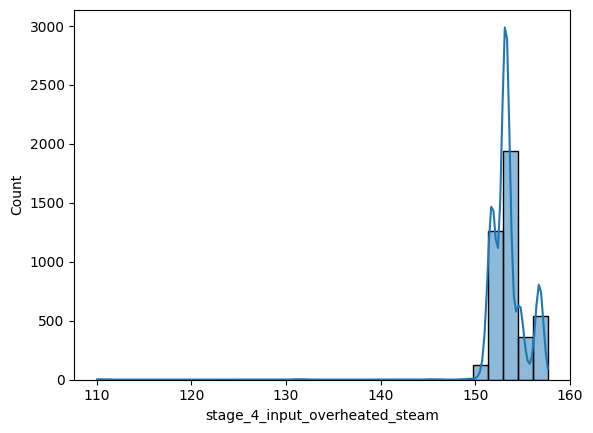

In [573]:
print(df['stage_4_input_overheated_steam'].mean())
print(df['stage_4_input_overheated_steam'].median())
sns.histplot(df['stage_4_input_overheated_steam'], kde=True, bins=30)

Есть какая- то анамалия, но в целом норм....

In [574]:
df['stage_4_input_overheated_steam'] = df['stage_4_input_overheated_steam'].fillna(df['stage_4_input_overheated_steam'].mean())
df['stage_4_input_overheated_steam'].isna().sum()

0

### Распределние

<Axes: xlabel='stage_1_output_konv_avd', ylabel='Density'>

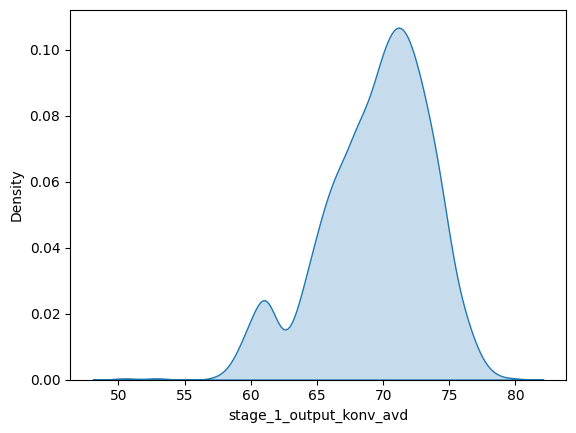

In [575]:
sns.kdeplot(data=df, x='stage_1_output_konv_avd', fill=True)

<Axes: xlabel='stage_2_input_water_sum', ylabel='Density'>

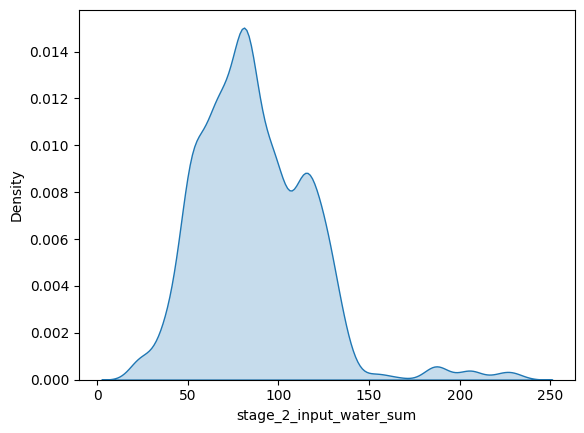

In [576]:
sns.kdeplot(data=df, x='stage_2_input_water_sum', fill=True)

<Axes: xlabel='stage_2_output_bottom_pressure', ylabel='Density'>

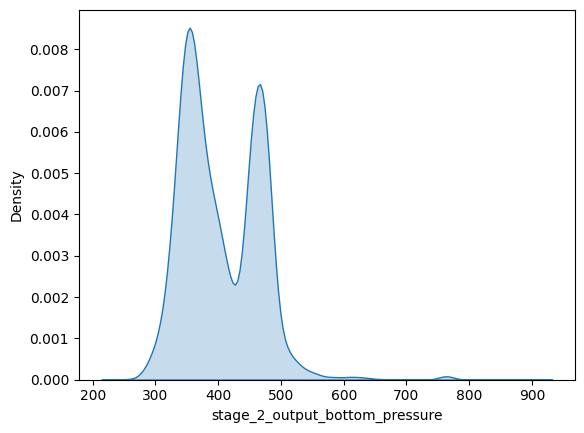

In [577]:
sns.kdeplot(data=df, x='stage_2_output_bottom_pressure', fill=True)

<Axes: xlabel='stage_2_output_bottom_temp', ylabel='Density'>

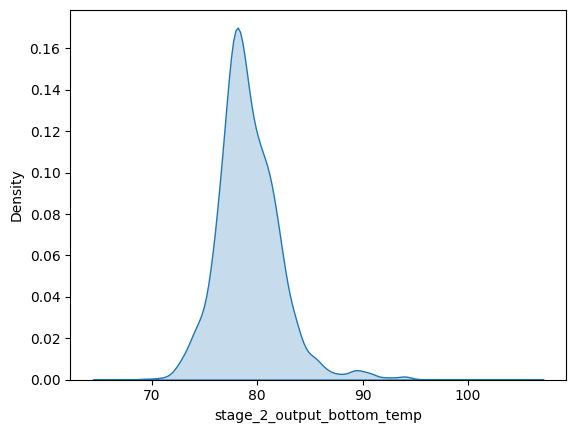

In [578]:
sns.kdeplot(data=df, x='stage_2_output_bottom_temp', fill=True)

<Axes: xlabel='stage_2_output_top_pressure', ylabel='Density'>

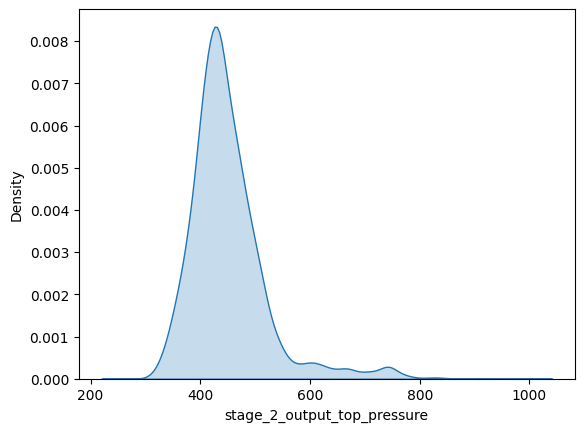

In [579]:
sns.kdeplot(data=df, x='stage_2_output_top_pressure', fill=True)

<Axes: xlabel='stage_2_output_top_pressure_at_end', ylabel='Density'>

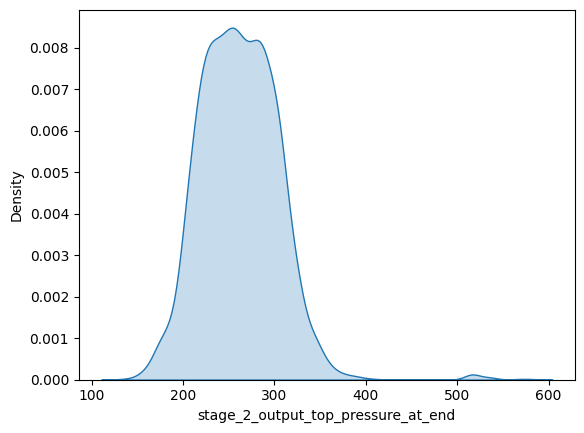

In [580]:
sns.kdeplot(data=df, x='stage_2_output_top_pressure_at_end', fill=True)

<Axes: xlabel='stage_3_input_pressure', ylabel='Density'>

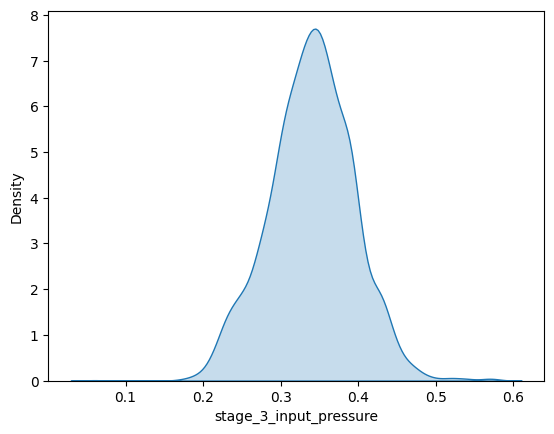

In [581]:
sns.kdeplot(data=df, x='stage_3_input_pressure', fill=True)

<Axes: xlabel='stage_3_output_temp_hum_steam', ylabel='Density'>

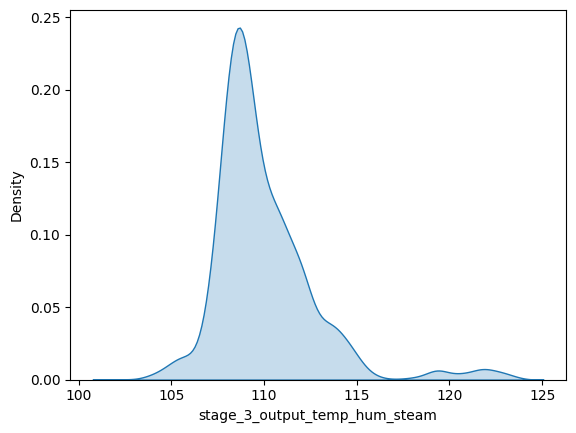

In [582]:
sns.kdeplot(data=df, x='stage_3_output_temp_hum_steam', fill=True)

<Axes: xlabel='stage_3_output_temp_top', ylabel='Density'>

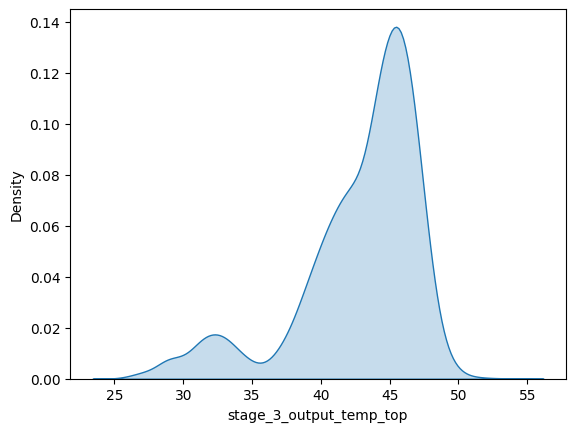

In [583]:
sns.kdeplot(data=df, x='stage_3_output_temp_top', fill=True)

<Axes: xlabel='stage_4_input_overheated_steam', ylabel='Density'>

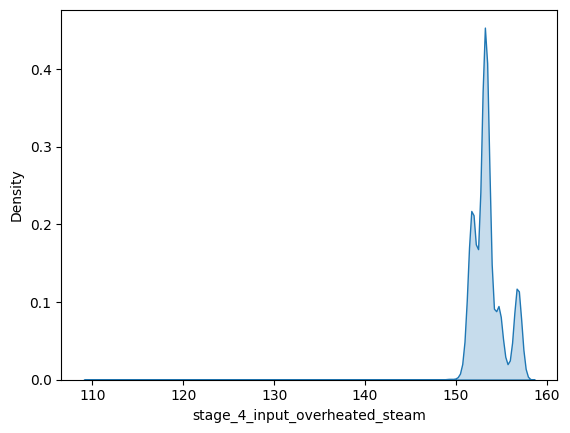

In [584]:
sns.kdeplot(data=df, x='stage_4_input_overheated_steam', fill=True)

<Axes: xlabel='stage_4_output_danger_gas', ylabel='Density'>

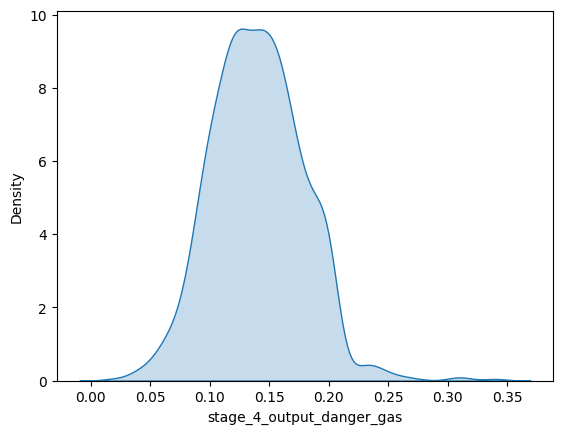

In [585]:
sns.kdeplot(data=df, x='stage_4_output_danger_gas', fill=True)

In [ ]:
#Тыкаюсь с выбросами

#Этой штукой я искал выбрался. Да не очень правильно, но ладно
# print(df.shape)
# for i in df.columns[1:]:
#     curr_df = df[i].describe()
#     H = curr_df.iloc[6] - curr_df.iloc[4]
#     no_upper = curr_df.iloc[4] + H * 3
#     no_lower = curr_df.iloc[6] - H * 3
#     print(len(df[(df[i] > no_upper)][i]), i)
#     print('------')    
#     df = df[(df[i] <= no_upper)]

#Думаю что в выбрасывать по нижней границы грустно, неправильно и печально


fqw = ['stage_2_input_water_sum', 'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp', 'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum', 'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end', 'stage_2_output_top_temp', 'stage_3_input_pressure', 'stage_3_input_soft_water', 'stage_3_output_temp_hum_steam', 'stage_4_input_overheated_steam', 'stage_4_input_water', 'stage_4_output_danger_gas']

#Таааакс что мы тут видим.
#Те у которых нет выбросов:
# *stage_1_output_konv_avd
# *stage_2_output_top_vacuum
# *stage_3_input_steam
# *stage_3_output_temp_top
# *stage_4_input_polymer
# *stage_4_input_steam
# *stage_4_output_dry_residue_avg
# *stage_4_output_product
# *work_shift



fqq = ['stage_2_input_water_sum', 'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp', 'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum', 'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end', 'stage_2_output_top_temp', 'stage_3_input_pressure', 'stage_3_input_soft_water', 'stage_3_output_temp_hum_steam', 'stage_4_input_overheated_steam', 'stage_4_input_water', 'stage_4_output_danger_gas']

#Всего 4240 данных, тогда стоит подумать много ли подобных данны чтобы их удалить? заменить? что стоит вообще сделать?
#Проверю данных на нормальность 

#Те у кого есть выбросы (выброс кол-во выбросов):
# *stage_2_input_water_sum              63   
# *stage_2_output_bottom_pressure       10  
# *stage_2_output_bottom_temp           70  
# *stage_2_output_bottom_temp_hum_steam 1   
# *stage_2_output_bottom_vacuum         76  
# *stage_2_output_top_pressure          121 
# *stage_2_output_top_pressure_at_end   16  
# *stage_2_output_top_temp              6   
# *stage_3_input_pressure               10  
# *stage_3_input_soft_water             15  
# *stage_3_output_temp_hum_steam        108 
# *stage_4_input_overheated_steam       6   
# *stage_4_input_water                  46  
# *stage_4_output_danger_gas            4   


koalit = []
for i in df.columns[1:]:
    _, res = shapiro(df[i])
    if res >= 0.05:
        koalit.append([i, 'нормальное'])
    else:
        koalit.append([i, 'ненормальное'])
print(koalit)
#Все ненормальные...ну из графиков конечно было очевидно, тогда думаю логично было бы выбросы ЕСЛИ И ЗАМЕНЯТЬ, то делать это медианой....
#Нужно будет подумать

#Я щас не искал верхние и нижние границы. НЕ ЗАБЫТЬ!!!!!!!!!!!

[['stage_1_output_konv_avd', 'ненормальное'], ['stage_2_input_water_sum', 'ненормальное'], ['stage_2_output_bottom_pressure', 'ненормальное'], ['stage_2_output_bottom_temp', 'ненормальное'], ['stage_2_output_bottom_temp_hum_steam', 'ненормальное'], ['stage_2_output_bottom_vacuum', 'ненормальное'], ['stage_2_output_top_pressure', 'ненормальное'], ['stage_2_output_top_pressure_at_end', 'ненормальное'], ['stage_2_output_top_temp', 'ненормальное'], ['stage_2_output_top_vacuum', 'ненормальное'], ['stage_3_input_pressure', 'ненормальное'], ['stage_3_input_soft_water', 'ненормальное'], ['stage_3_input_steam', 'ненормальное'], ['stage_3_output_temp_hum_steam', 'ненормальное'], ['stage_3_output_temp_top', 'ненормальное'], ['stage_4_input_overheated_steam', 'ненормальное'], ['stage_4_input_polymer', 'ненормальное'], ['stage_4_input_steam', 'ненормальное'], ['stage_4_input_water', 'ненормальное'], ['stage_4_output_danger_gas', 'ненормальное'], ['stage_4_output_dry_residue_avg', 'ненормальное'], [

<Axes: >

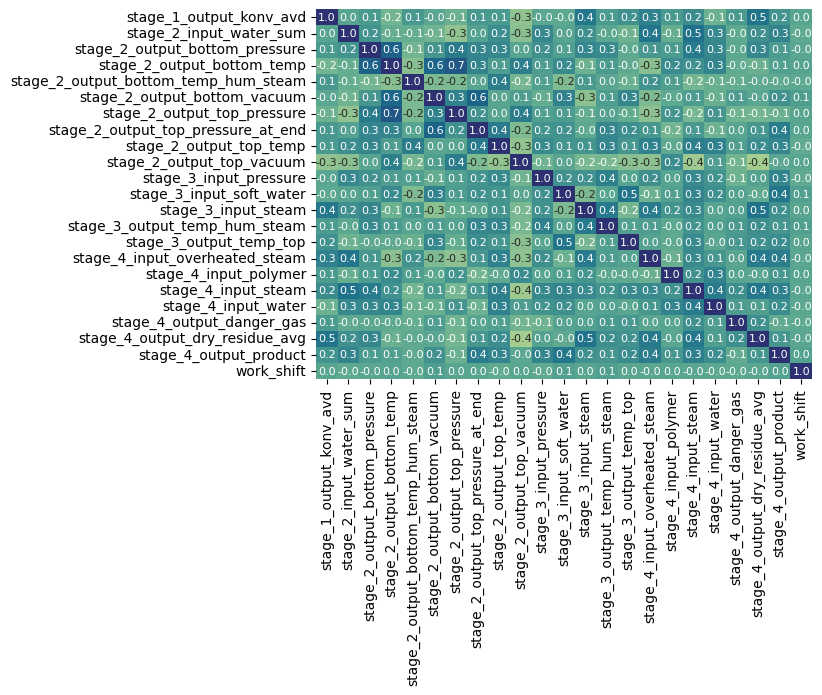

In [ ]:
spec_df = df.drop('datetime', axis=1)

correlation_matrix = spec_df.corr(method='spearman')
# по приколу хочу глянуть матрицу корреляций...можно за одно heatmap составить
sns.heatmap(correlation_matrix, cmap="crest", fmt='.1f', cbar=False, annot=True, annot_kws={"size": 8})

# стоит ли добавлять work_shift в матрицу корреляций???

#stage_2_output_bottom_temp + stage_2_output_bottom_temp           0.6
#stage_2_output_top_pressure + stage_2_output_bottom_temp          0.7
#stage_2_output_bottom_vacuum + stage_2_output_top_pressure_at_end 0.6
#stage_4_input_steam + stage_2_input_water_sum                     0.5
#stage_4_output_dry_residue_avg + stage_1_output_konv_avd          0.5
#stage_4_output_dry_residue_avg + stage_3_input_steam              0.5

#глаза слипаются не дам быструю аналитику вот этого, разберайтеся сами утром.
#гипотезы щас не придумаю сорян....
#